# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Задачи исследования
**1. Загрузка и подготовка данных**.

**2. Обучить и проверить модель для каждого региона**:
- разбить данные на обучающую и валидационную выборки в соотношении 75:25;
- обучить модель и сделать предсказания на валидационной выборке;
- сохранить предсказания и правильные ответы на валидационной выборке;
- напечатать на экране средний запас предсказанного сырья и RMSE модели;
- проанализировать результаты.

**3. Подготовка к расчёту прибыли**:
- все ключевые значения для расчётов сохранить в отдельных переменных;
- рассчитать достаточный объём сырья для безубыточной разработки новой скважины; сравнить полученный объём сырья со средним запасом в каждом регионе;
- написать выводы по этапу подготовки расчёта прибыли.

**4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**
- выбрать скважины с максимальными значениями предсказаний;
- просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям;
- рассчитать прибыль для полученного объёма сырья.

**5. Посчитать риски и прибыль для каждого региона:**
- применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли;
- найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков; убыток — это отрицательная прибыль;
- написать выводы: предложить регион для разработки скважин и обосновать выбор.

# Описание данных
**Признаки**
- *id* — уникальный идентификатор скважины;
- *f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы);
---
**Целевой признак**
- *product* — объём запасов в скважине (тыс. баррелей).

# Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
---
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Общая информация

In [1]:
!pip install matplotlib --upgrade
!pip install scikit-learn==1.1.3

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings

from scipy import stats as st
from scipy.stats import randint

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from numpy.random import RandomState

from sklearn.utils import shuffle
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm


warnings.filterwarnings("ignore")

     |████████████████████████████████| 11.6 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 82.7 MB/s eta 0:00:01
     |████████████████████████████████| 299 kB 94.2 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
     |████████████████████████████████| 30.8 MB 1.0 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
pip show matplotlib

Name: matplotlib
Version: 3.7.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /opt/conda/lib/python3.9/site-packages
Requires: kiwisolver, pillow, fonttools, pyparsing, numpy, cycler, python-dateutil, contourpy, importlib-resources, packaging
Required-by: seaborn, pyod, catboost
Note: you may need to restart the kernel to use updated packages.


In [3]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv') # загрузим данные из файла в датафрейм
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

**Напишем собственную функцию для вывода общей информации о данных по каждому датафрейму**

In [4]:
def check_data_info(*dfs):
    count=0
    for df in dfs:
        
        print ('\033[1m\033[36m' + 'Изучим исходные данные в ' +  'df_' + str(count) + '\033[0m')
        
        print(df.info())
       
        missed_cells = df.isna().sum().sum()/(df.shape[0]*(df.shape[1]-1))
        missed_rows = sum(df.isna().sum(axis=1)>0)/df.shape[0]
        print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
        print ('Количество пропусков: {:.0f}'.format(df.isna().sum().sum()))
        print ('Количество пропусков в каждом столбце')
        print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
        print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))
        display(df.isna().sum())
        ## Проверим дубликаты
        print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
        print('Количество полных дубликатов: ', df.duplicated().sum())
        ## Посмотрим на сами данные
        print ('\033[1m' + '\nПервые пять строк датасета:'+ '\033[0m')
        display(df.head())
        print('----------------------------------\n')
        count += 1

In [5]:
check_data_info(df_0, df_1, df_2)

Изучим исходные данные в df_0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Проверка пропусков
Количество пропусков: 0
Количество пропусков в каждом столбце
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


----------------------------------

Изучим исходные данные в df_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Проверка пропусков
Количество пропусков: 0
Количество пропусков в каждом столбце
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


----------------------------------

Изучим исходные данные в df_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Проверка пропусков
Количество пропусков: 0
Количество пропусков в каждом столбце
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


----------------------------------



**Видим, что:**
- в каждом датафрейме по 100 000 строк и 5 колонок с фичами: `id`, `f0`, `f1`, `f2`; целевым признаком - `product`;
- в данных отсутствуют полные дубликаты или пропуски;
- типы данных соответствуют их природе.

**Напишем собственную функцию для вывода информации о категориальных данных по каждому датафрейму**

In [6]:
def categorical(*dfs):
    count=0
    for df in dfs:
        print('\033[1m\033[36m' + '\nОписание категориальных данных в ' + 'df_' + str(count) + '\033[0m')
        if True in (df.dtypes == object).tolist():
            display(df.describe(include='object').T)
        else:
            print('категориальные данные отсутствуют')
    
    
        print('\033[1m' + '\nВывод уникальных значений по каждому категориальному признаку в ' + 'df_' + str(count) + '\033[0m')    
        df_object = df.select_dtypes(include='object').columns
    
        for i in df_object:
            print('\033[1m' + '_'+ str(i) + '\033[0m')
            display(df[i].value_counts())
        count += 1


In [7]:
categorical(df_0, df_1, df_2)       


Описание категориальных данных в df_0


,count,unique,top,freq
id,100000,99990,QcMuo,2



Вывод уникальных значений по каждому категориальному признаку в df_0
_id


QcMuo    2
Tdehs    2
AGS9W    2
A5aEY    2
fiKDv    2
        ..
2E82v    1
Ak9i3    1
O0ENk    1
TDgMU    1
ICNU6    1
Name: id, Length: 99990, dtype: int64


Описание категориальных данных в df_1


,count,unique,top,freq
id,100000,99996,5ltQ6,2



Вывод уникальных значений по каждому категориальному признаку в df_1
_id


5ltQ6    2
wt4Uk    2
LHZR0    2
bfPNe    2
Ma4Vy    1
        ..
CN8qO    1
MbBre    1
KoATh    1
Hff7t    1
2WJge    1
Name: id, Length: 99996, dtype: int64


Описание категориальных данных в df_2


,count,unique,top,freq
id,100000,99996,VF7Jo,2



Вывод уникальных значений по каждому категориальному признаку в df_2
_id


VF7Jo    2
Vcm5J    2
xCHr8    2
KUPhW    2
vSCmb    1
        ..
6Bm1t    1
bmyj7    1
FD8oC    1
ltGLN    1
swCAx    1
Name: id, Length: 99996, dtype: int64

**Видим, что:**
- в каждом датафрейме фактическое каждое значение в столбце `id` является уникальным;
- соответственно для нашей задачи данный столбец является малоинформативным, из него нельзя извлечечь какие-либо регулярности, полезные для нашей модели

In [8]:
df_0 = df_0.drop(['id'], axis=1) # удалим неинформативные столбцы
df_1 = df_1.drop(['id'], axis=1)
df_2 = df_2.drop(['id'], axis=1)

display(df_0.head()) # check
display(df_1.head())
df_2.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


### Визуализация и описательная статистика

**Напишем собственные функции для вывода графиков - гистограмм и диаграмм размаха для количесвенных переменных по каждому датафрейму**

In [9]:
def plot_hist(col_column, *dfs):
    '''
    Функция отрисовки гистограмм для количественных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = 3
    f, ax = plt.subplots(rows, 4, figsize=(8, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(20)
    plt.rcParams.update({'font.size': 18})
    
 
    count=0
    for df in dfs:        
        for i, col in enumerate(col_column):
            sns.histplot(df[col], kde=True, bins=24, ax = ax[count, i], edgecolor='black', linewidth=2)                    
        #sns.boxplot(data[col], ax = ax[i, 1])
            
            #ax[i, 0].set_xlabel(col)
            #ax[i, 1].set_xlabel(col)
            ax[i-1, 0].set_ylabel('df_' + str(i-1), fontsize=22)
        count+=1
    plt.suptitle("Гистограммы для количественных данных", fontsize=30, y=1.01)
    plt.show()

In [10]:
def plot_box(col_column, *dfs):
    '''
    Функция отрисовки гистограмм и ящика с усами для количественных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = 3
    f, ax = plt.subplots(rows, 4, figsize=(15, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(20)
    plt.rcParams.update({'font.size': 18})
    
 
    count=0
    for df in dfs:        
        for i, col in enumerate(col_column):
            sns.boxplot(df[col], ax = ax[count, i])
            
            #ax[i, 0].set_xlabel(col)
            #ax[i, 1].set_xlabel(col)
            ax[i-1, 0].set_ylabel('df_' + str(i-1), fontsize=22)
        count+=1
    plt.suptitle("Диаграммы размаха для количественных данных", fontsize=30, y=1.01)
    plt.show()

**Напишем собственную функцию для вывода описательной статистики для количесвенных переменных по каждому датафрейму**

In [11]:
def statisticks(*dfs):
    count=0
    for df in dfs:
        print('\033[1m\033[36m' + '\nОписание количественных данных в '+ 'df_' + str(count) + '\033[0m')
        display(df.describe().T)  
        count += 1

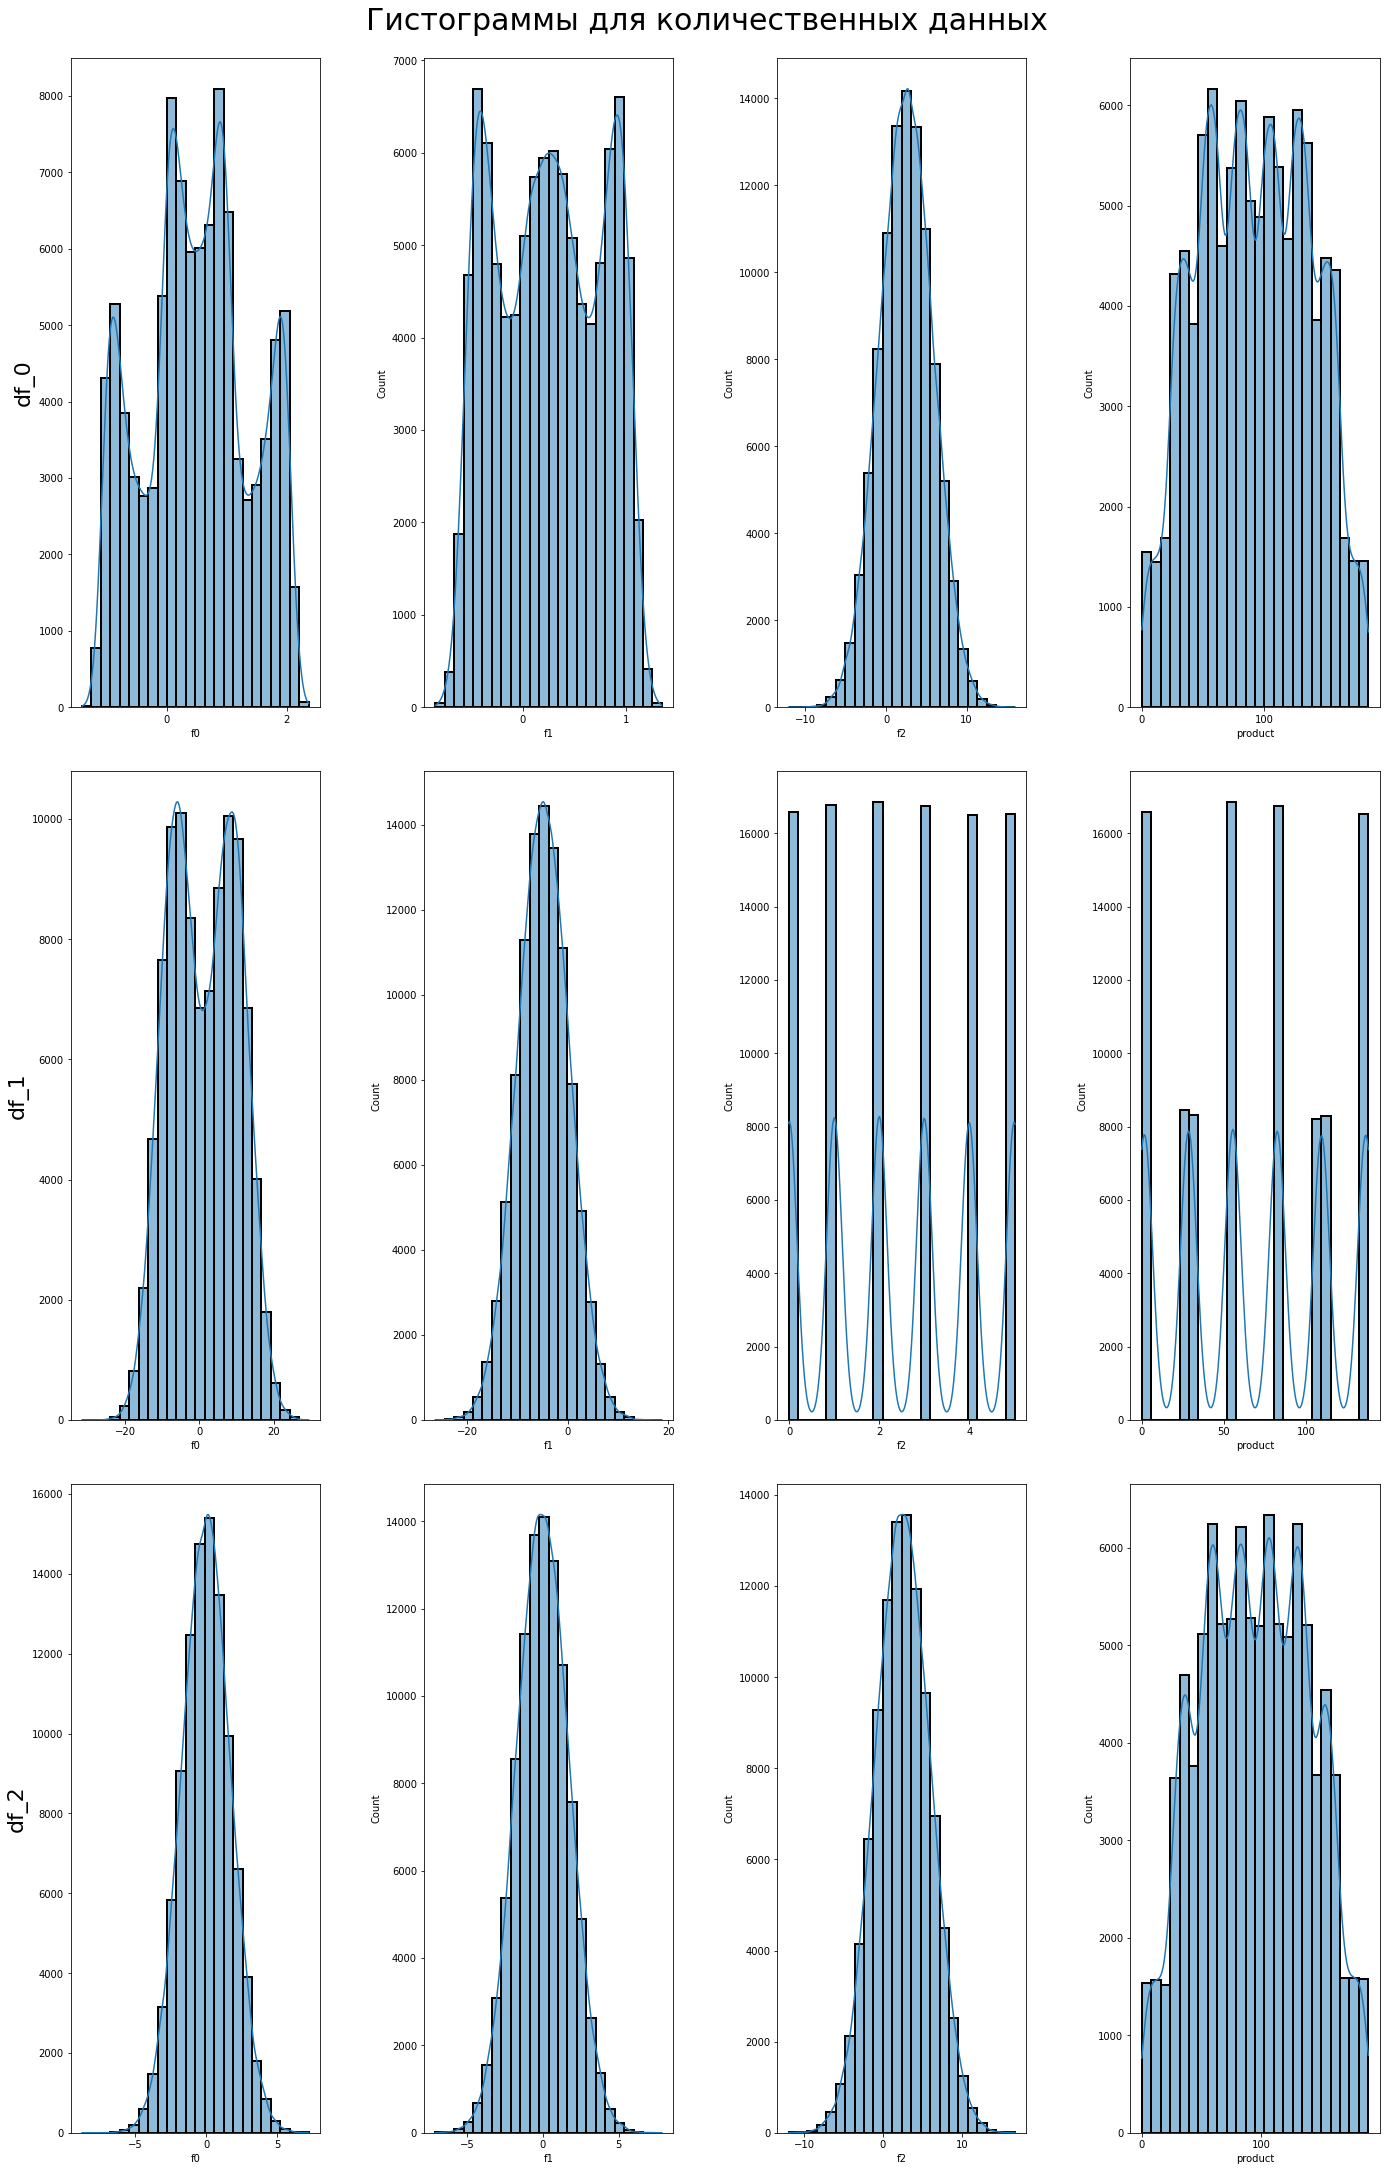

In [12]:
plot_hist(df_0.columns, df_0, df_1, df_2)

In [13]:
statisticks(df_0, df_1, df_2)


Описание количественных данных в df_0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347



Описание количественных данных в df_1


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408



Описание количественных данных в df_2


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


In [14]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) # л.-функция для расчета коэфициента вариации
#calculate CV
print('Коэфициент вариации для df_0\n', cv(df_0))
print('Коэфициент вариации для df_1\n', cv(df_1))
print('Коэфициент вариации для df_2\n', cv(df_2))

Коэфициент вариации для df_0
 f0         1.742203
f1         2.016577
f2         1.297925
product    0.478797
dtype: float64
Коэфициент вариации для df_1
 f0         7.855922
f1        -1.067401
f2         0.682920
product    0.667554
dtype: float64
Коэфициент вариации для df_2
 f0         856.304791
f1        -831.717583
f2           1.392091
product      0.471052
dtype: float64


**Видим, что:**
1. **`f0` имеет различное ненормальное распределение в df_0 - df_2**:
- **`df_0`**: 
    - мультимодальность (4 моды), 
    - симметричность (Хср.~Me),
    - размах данных от -1.4 до 2.4,
    - наиболее репрезентативная часть данных (Q1-Q3): от -0.07 до 1,07;
    - коф-т вариации > 0.33: высокая степень рассеивания, неоднородная совокупность;
- **`df_1`**: 
    - бимодальность, 
    - симметричность (Хср.~Me),
    - размах данных от -31.6 до 29.4,
    - наиболее репрезентативная часть данных (Q1-Q3): от -6.3 до 8,6;
    - коф-т вариации > 0.33: очень высокая степень рассеивания, неоднородная совокупность;
- **`df_2`**: 
    - унимодальность, 
    - имеет незначительную левостороннюю асимметрию: Хср. < Me, следовательно распределение имеют тенденцию, скорее, к уменьшению соответствующих показателей (регрессивности),
    - размах данных от -31.6 до 29.4,
    - наиболее репрезентативная часть данных (Q1-Q3): от -8.8 до 7,2;
    - коф-т вариации > 0.33: чрезвычайно высокая степень рассеивания, неоднородная совокупность.
2. **`f1` имеет различное ненормальное распределение в df_0 - df_2**:
- **`df_0`**: 
    - мультимодальность (3 моды), 
    - симметричность (Хср.~Me),
    - размах данных от -0.85 до 1.34,
    - наиболее репрезентативная часть данных (Q1-Q3): от -0.2 до 0,7;
    - коф-т вариации > 0.33: высокая степень рассеивания, неоднородная совокупность; 
- **`df_1`**: 
    - унимодальность, 
    - симметричность (Хср.~Me),
    - размах данных от -26.4 до 18.7,
    - наиболее репрезентативная часть данных (Q1-Q3): от -8.3 до -1,3;
    - коф-т вариации < -0.33: высокая степень рассеивания, неоднородная совокупность;
- **`df_2`**: 
    - унимодальность, 
    - имеет незначительную левостороннюю асимметрию: Хср. > Me, следовательно распределение имеют тенденцию, скорее, к увеличению соответствующих показателей (прогрессивности),
    - размах данных от -7 до 7.8,
    - наиболее репрезентативная часть данных (Q1-Q3): от -1.17 до 1,16;
    - коф-т вариации < -0.33: чрезвычайно высокая степень рассеивания, неоднородная совокупность. 
3. **`f2` имеет различное ненормальное распределение в df_0 - df_2**:
- **`df_0`**: 
    - унимодальность, 
    - симметричность (Хср.~Me),
    - размах данных от -12 до 16,
    - наиболее репрезентативная часть данных (Q1-Q3): от 0.3 до 4,7;
    - коф-т вариации > 0.33: высокая степень рассеивания, неоднородная совокупность; 
- **`df_1`**: 
    - мультимодальность: данные группируются вокруг значений: 0,1,2,3,4,5, 
    - имеет левостороннюю асимметрию: Хср. > Me, следовательно распределение имеют тенденцию, скорее, к увеличению соответствующих показателей (прогрессивности),
    - размах данных от -0.02 до 5.02,
    - наиболее репрезентативная часть данных (Q1-Q3): от 1 до 4;
    - коф-т вариации > 0.33: высокая степень рассеивания, неоднородная совокупность;
- **`df_2`**: 
    - унимодальность, 
    - симметричность (Хср.~Me),
    - размах данных от -12 до 16.7,
    - наиболее репрезентативная часть данных (Q1-Q3): от 0.13 до 4,86;
    - коф-т вариации < -0.33: чрезвычайно высокая степень рассеивания, неоднородная совокупность. 
4. **`product` имеет различное ненормальное распределение в df_0 - df_2**:
- **`df_0`**: 
    - возможная мултимодальность, 
    - симметричность (Хср.~Me),
    - размах данных от 0 до 185,
    - наиболее репрезентативная часть данных (Q1-Q3): от 56.5 до 128,6;
    - коф-т вариации 0.47 > 0.33: высокая степень рассеивания, неоднородная совокупность; 
- **`df_1`**: 
    - мультимодальность: данные группируются вокруг значений: 0,25,75,100,125, 
    - имеет левостороннюю асимметрию: Хср. > Me, следовательно распределение имеют тенденцию, скорее, к увеличению соответствующих показателей (прогрессивности),
    - размах данных от 0 до 138,
    - наиболее репрезентативная часть данных (Q1-Q3): от 26.9 до 107.8;
    - коф-т вариации 0.67 > 0.33: высокая степень рассеивания, неоднородная совокупность;
- **`df_2`**: 
    - возможная мултимодальность, 
    - симметричность (Хср.~Me),
    - размах данных от 0 до 190,
    - наиболее репрезентативная часть данных (Q1-Q3): от 59.5 до 130,6;
    - коэф-т вариации 0.47 > 0.33: высокая степень рассеивания, неоднородная совокупность.
---
**Итак**,
1. **Распределение значений признаков по трем регионам, как правило, существенно отличаются, как по диапазону данных, так и по статистикам**. 
2. **Имеющиеся сходства позволяют заключить, что 1-е и 3-е месторождения по исследуемым признакам ближе друг к другу, чем каждый из них ко 2-му месторождению (в части `f1`, `f2`, `product`)**.
3. **При этом 3-й регион имеет скважину с наибольшим объёмом запасов в скважине - 190 тыс.бар.; наиболее репрезентативная часть данных (Q1-Q3): от 59.5 до 130,6, содержит наибольшее интервальное значение; наименьший разброс в данных**

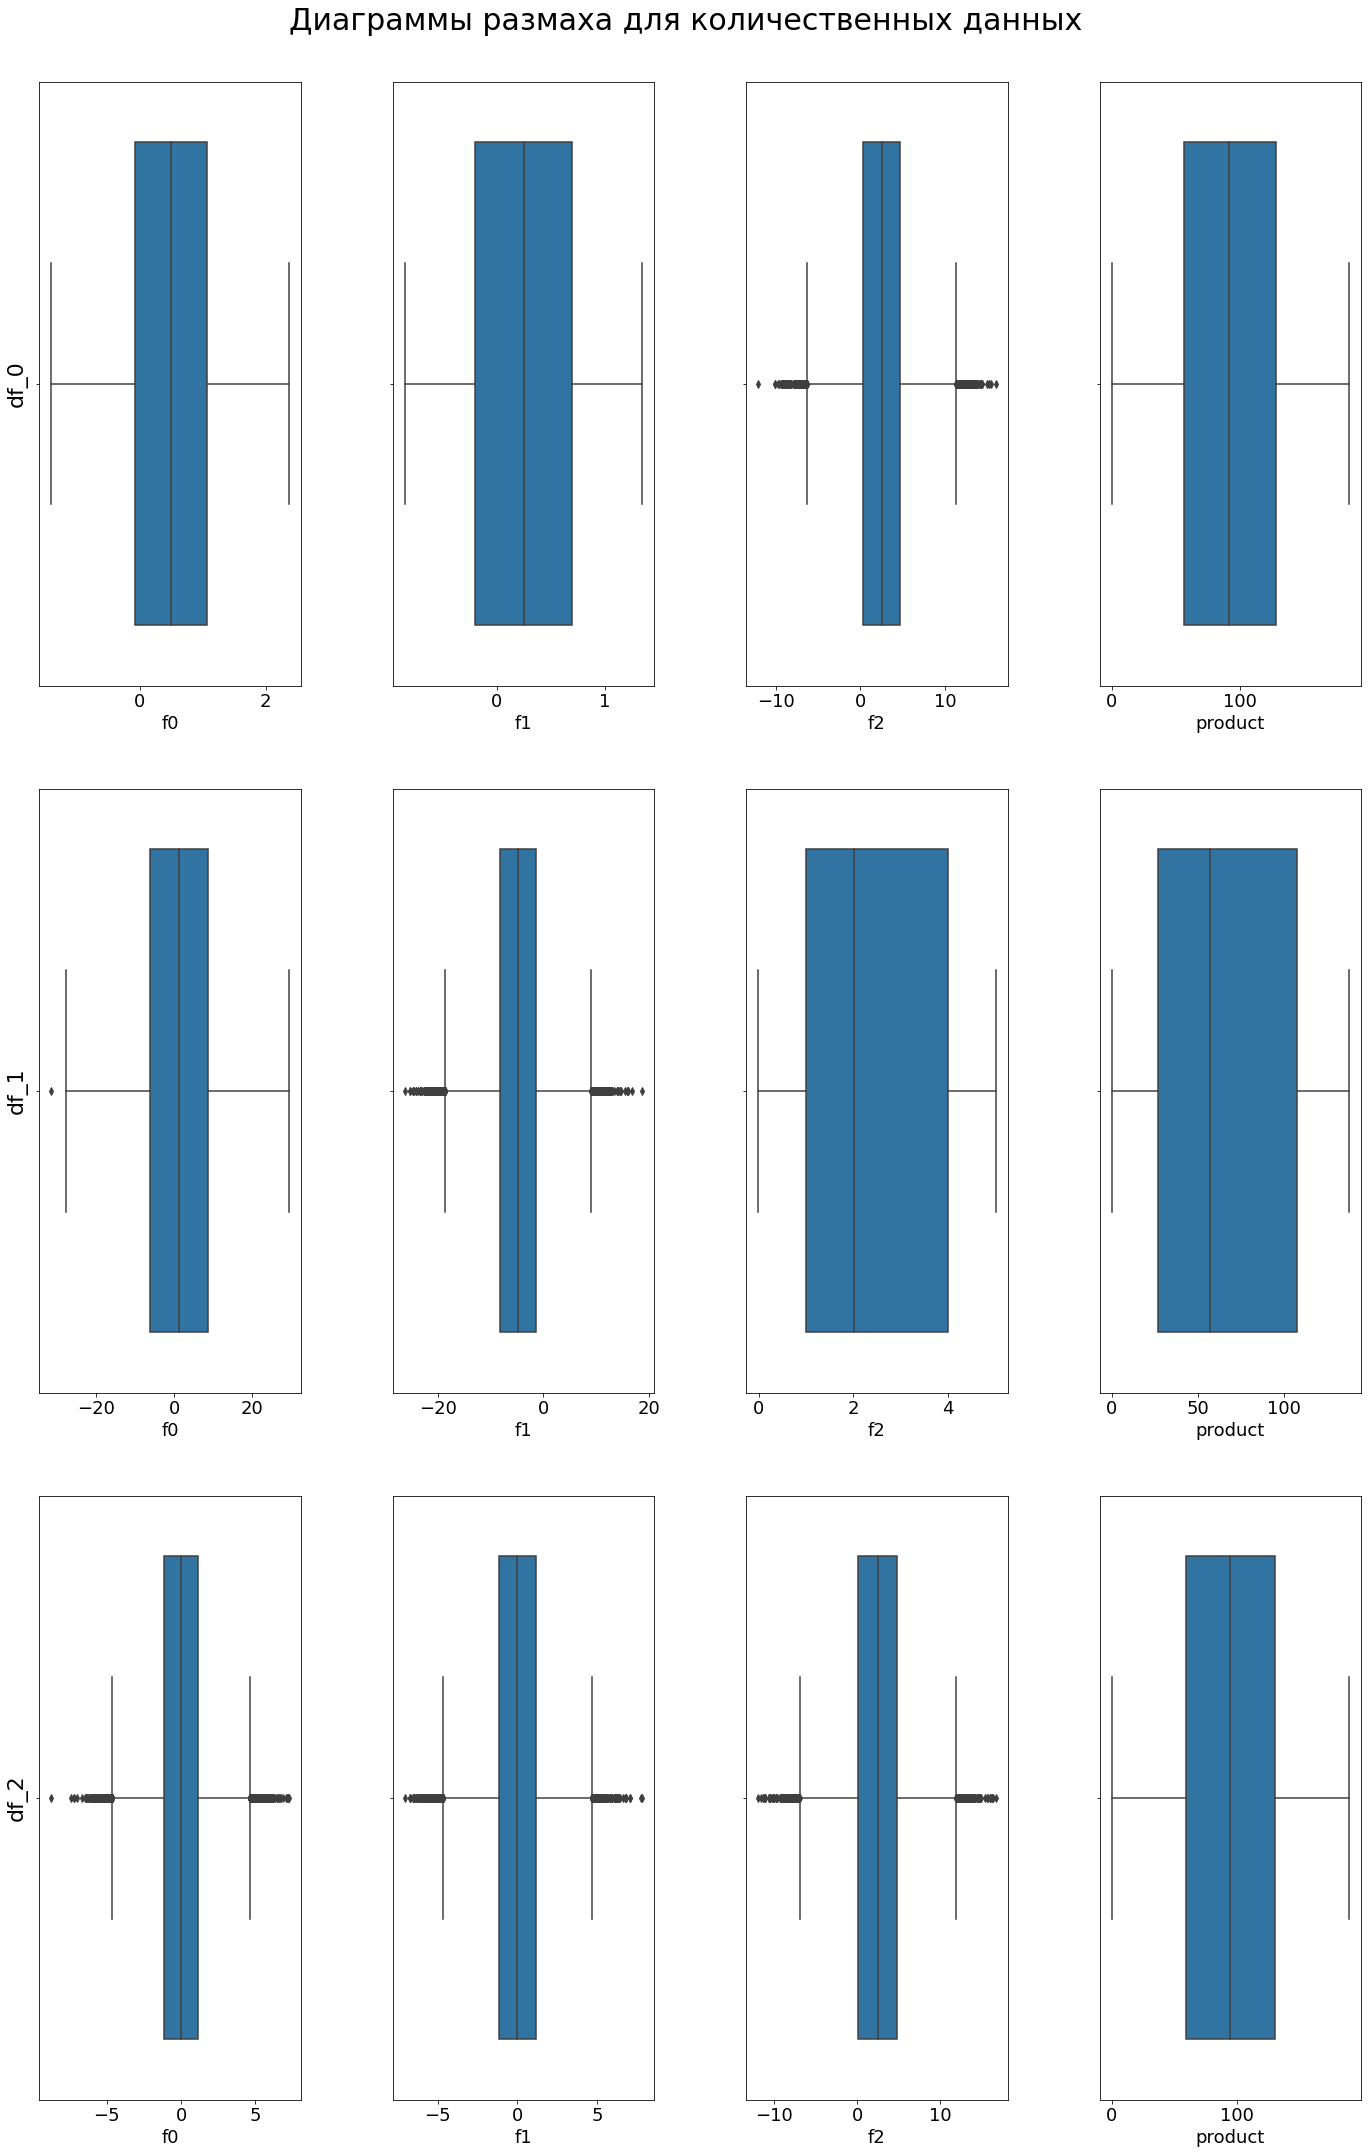

In [15]:
plot_box(df_0.columns, df_0, df_1, df_2)

**Обратим внимание, что в некоторых столбцах имеется немало выбросов. Так как модель линейной регрессии очень чувстиветльна к выбросам, целесообразно удалить их, если это существенно не уменьшит объем данных для обучения. Столбцы с выбросами**:
1) df_0: `f2`
2) df_1: `f1`
3) df_2: `f0`, `f1`, `f2`

### Устраняем аномалии в данных

Постараемся избавиться от аномалий с помощью **метода межквартильного диапазона**:

In [16]:
df_0_clean = df_0.copy()
df_1_clean = df_1.copy()
df_2_clean = df_2.copy()

In [17]:
def iqr_transform(*dfs): # исследуем, какое количество данных будет удалено с помощью указанного метода
    for df in dfs:
        Q1 = df.quantile(q=.25)
        Q3 = df.quantile(q=.75)
        IQR = Q3 - Q1
        df = df[~((df < (Q1-1.5*IQR)) | (df > (Q3+1.5*IQR))).any(axis=1)]
        print(df.shape)

In [18]:
iqr_transform(df_0_clean, df_1_clean, df_2_clean)

(99494, 4)
(99363, 4)
(98004, 4)


Видим, что, если применить метод IQR, будет удалено:
- 0,5% данных из df_0;
- 0,65% данных из df_1;
- около 2 % из df_2.
---
В целом, в пределах нормы (не более 5% от всех данных), с учетом общего объема данных

In [19]:
Q1 = df_0_clean.quantile(q=.25)
Q3 = df_0_clean.quantile(q=.75)
IQR = Q3 - Q1
df_0_clean = df_0_clean[~((df_0_clean < (Q1-1.5*IQR)) | (df_0_clean > (Q3+1.5*IQR))).any(axis=1)]
print(df_0_clean.shape)

(99494, 4)


In [20]:
Q1 = df_1_clean.quantile(q=.25)
Q3 = df_1_clean.quantile(q=.75)
IQR = Q3 - Q1
df_1_clean = df_1_clean[~((df_1_clean < (Q1-1.5*IQR)) | (df_1_clean > (Q3+1.5*IQR))).any(axis=1)]
print(df_1_clean.shape)

(99363, 4)


In [21]:
Q1 = df_2_clean.quantile(q=.25)
Q3 = df_2_clean.quantile(q=.75)
IQR = Q3 - Q1
df_2_clean = df_2_clean[~((df_2_clean < (Q1-1.5*IQR)) | (df_2_clean > (Q3+1.5*IQR))).any(axis=1)]
print(df_2_clean.shape)

(98004, 4)


**Посмотрим на диаграммы размах после очистки данных**

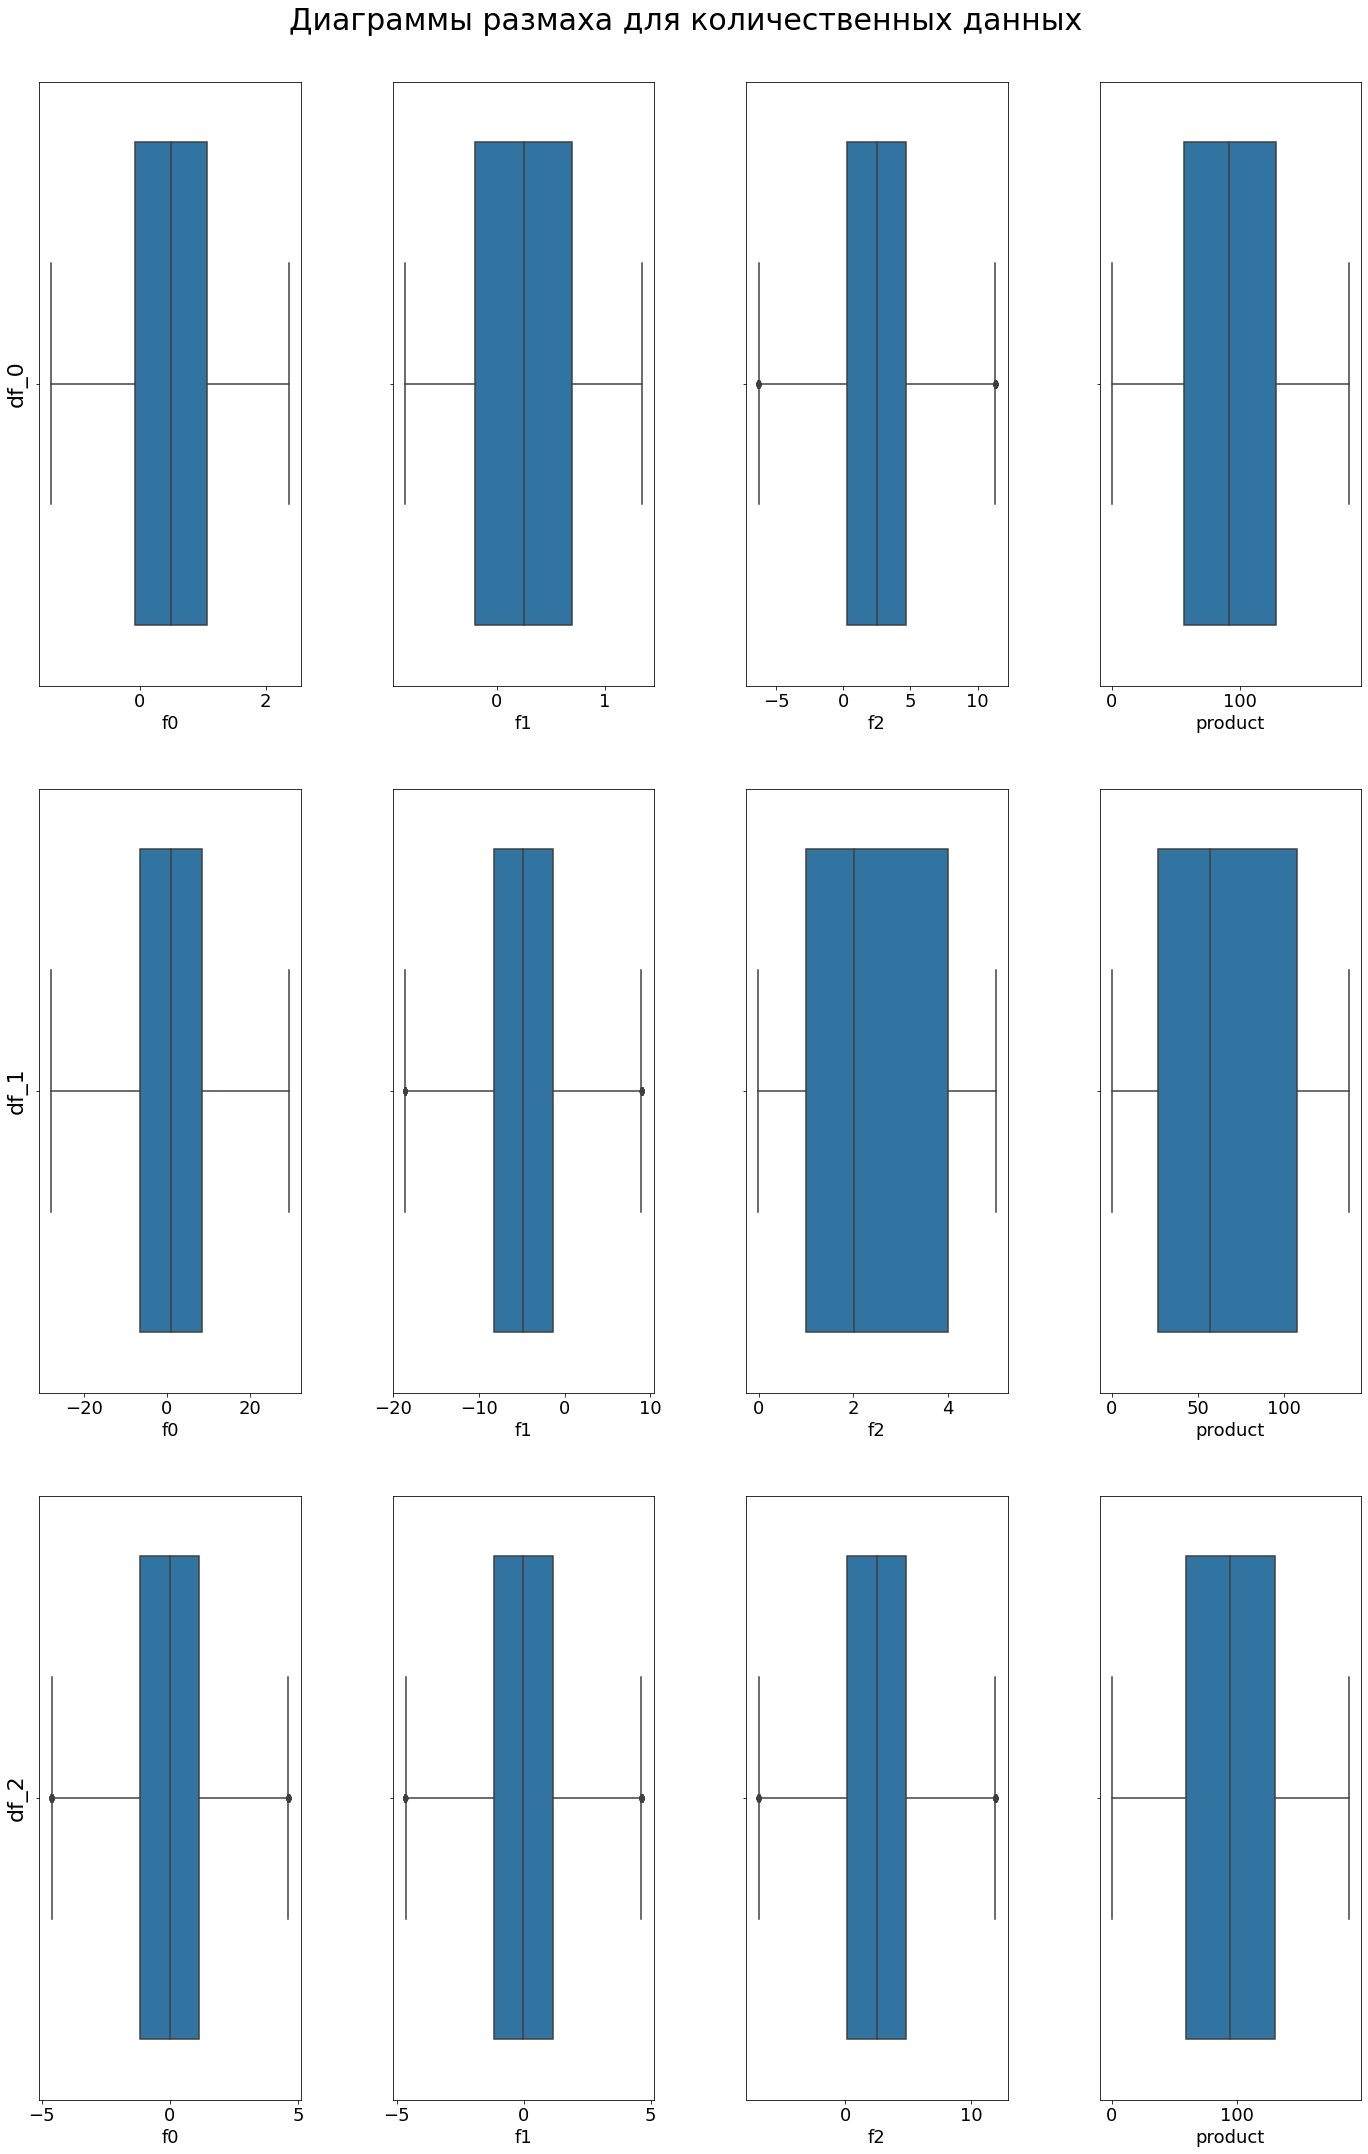

In [22]:
plot_box(df_0_clean.columns, df_0_clean, df_1_clean, df_2_clean)

**Выбросы удалены**

### Корреляционный анализ

In [23]:
def df_heatmap(*dfs): # исследуем, какое количество данных будет удалено с помощью указанного метода
    count = 0
    for df in dfs:
        sns.set(font_scale=1.15)
        plt.figure(figsize=(8,4))
        plt.title('Корр. матрица: df_' + str(count), fontsize=15)
        sns.heatmap(df.corr(),
        cmap='RdBu_r', # задаём цветовую схему
        annot=True, # рисуем значения внутри ячеек
        vmin=-1, vmax=1), # указываем начало цветовых кодов от -1 до 1.
        count += 1

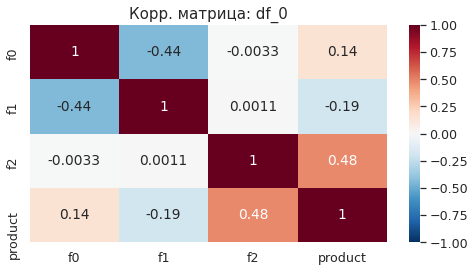

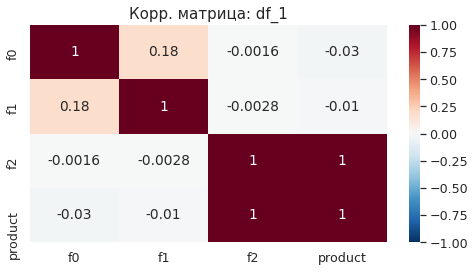

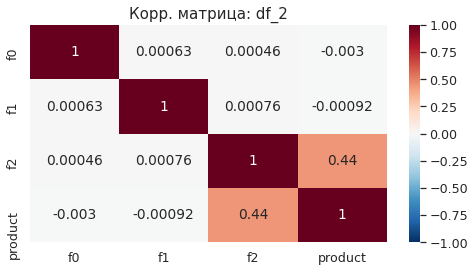

In [24]:
df_heatmap(df_0_clean, df_1_clean, df_2_clean)

**Видим:**
- `df_0`: между признаками f0 и f1 наблюдается умеренная отрицательная линейная зависимость; также наблюдается умеренная положительная связь между f2 и целевым признаком;

- `df_1`: между признаками f2 и целевым признаком наблюдается фактически функциональная линейная зависимость;

- `df_2`: наблюдается умеренная положительная связь между f2 и целевым признаком;
---

Для обучения моделей может быть важным наличие корр. зависимости между столбцами (предикторами) в датафрейме. Известно, что мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату. Кроме того, избыточные коэффициенты увеличивают сложность модели машинного обучения, а значит, время ее тренировки возрастает. 

---
Учитывая это, дополнительно **посчитаем коэффициент инфляции дисперсии (VIF)**: по сути, множитель, который увеличивает дисперсию (увеличение дисперсии по сравнению с тем, какой бы она была в случае однофакторной регрессии)

In [25]:
df_1_clean['product'].value_counts()

53.906522     8423
26.953261     8414
84.038886     8380
57.085625     8342
3.179103      8289
30.132364     8266
80.859783     8263
110.992147    8251
134.766305    8244
0.000000      8173
137.945408    8169
107.813044    8149
Name: product, dtype: int64

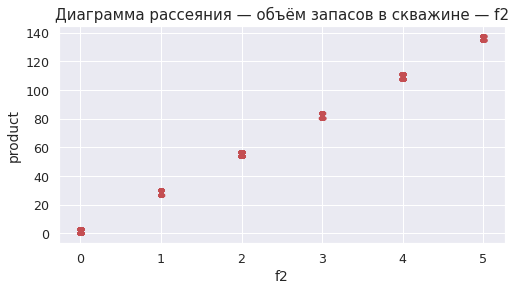

In [26]:
df_1_clean.plot(kind='scatter', y='product' , x='f2', alpha=0.5, figsize=(8,4), c = 'r', s = 10)
plt.title('Диаграмма рассеяния — объём запасов в скважине — f2', fontsize=15);

In [27]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('product ~ f0+f1+f2', data=df_0_clean, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

,VIF,variable
0,2.648245,Intercept
1,1.241063,f0
2,1.241051,f1
3,1.000011,f2


In [28]:
y, X = dmatrices('product ~ f0+f1+f2', data=df_1_clean, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

,VIF,variable
0,4.158703,Intercept
1,1.033078,f0
2,1.033084,f1
3,1.000009,f2


In [29]:
y, X = dmatrices('product ~ f0+f1+f2', data=df_2_clean, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif

,VIF,variable
0,1.541572,Intercept
1,1.000001,f0
2,1.000001,f1
3,1.000001,f2


Видим, что VIF ~ 1+, следовательно мультикол-ть в нашем наборе данных фактически отсутствует.

**Вывод:**

**1. Природа данных**:
- категориальные: id's; 
- количественные: остальные.

**2. В результате предобработки данных**:
- отсуствуют полные дубликаты;
- типы данных во всех столбцах соответствуют их природе;
- выявлено, что в датафрейме имеются неинформативные столбцы: `id`; удалены;
- в ходе корреляционного анализа была выявлено: мультикол-ть в нашем наборе данных фактически отсутствует.

**3. В ходе предобработки выявлено**:
- распределение значений признаков по трем регионам, как правило, существенно отличаются, как по диапазону данных, так и по статистикам;
- имеющиеся сходства позволяют заключить, что 1-е и 3-е месторождения по исследуемым признакам ближе друг к другу, чем каждый из них ко 2-му месторождению (в части `f1`, `f2`, `product`);
- при этом 3-й регион имеет скважину с наибольшим объёмом запасов в скважине - 190 тыс.бар., наиболее репрезентативная часть данных (Q1-Q3): от 59.5 до 130,6 содержит наибольшее интервальное значение; наименьший разброс в данных.

---
В целом, данные прошли необходимую прдобработку и готовы для обучения моделей.

In [30]:
!pip install -U pandas-profiling
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 324 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 43.3 MB/s eta 0:00:01
     |████████████████████████████████| 679 kB 91.6 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 60.4 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 68.4 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 103.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 77.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 67.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 74.4 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=74f9969dfabbce6b4d72701b428d02354fa2cdf936dfe13a25caf498331c8d86
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1

In [31]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_1_clean, title="Pandas Profiling Report")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
!pip install sweetviz

     |████████████████████████████████| 15.1 MB 1.3 MB/s eta 0:00:01


In [33]:
import sweetviz as sv

my_report = sv.analyze(df_1_clean)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [34]:
my_report = sv.compare(df_1_clean, df_1)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Обучение и проверка модели

**Напишем собственную функцию `region_prediction`, с помощью которой:**
1) разделим датафрейм на features and target;

2) разделим features на обучающую и валидационную выборки в соотношении 75:25;

3) c помощью класса Pipeline:
- объединим операции масштабирования признаков с созданием модели лин. рег-ии;
- обучим модель;
- сделаем предсказания на валидационной выборке;

4) посчитаем метрику RMSE;

5) сохраним в отдельных переменных предсказания, средний запас предсказанного сырья, средний запас фактического сырья и RMSE модели.

In [35]:
RANDOM_SEED = 42 # предварительно создадим переменную со значением "42" для последующего случайного характера разделения данных

In [36]:
def region_prediction(df):
   
    X = df.drop(["product"], axis=1)
    y = df["product"]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)
    
    pipe = make_pipeline(StandardScaler(),LinearRegression()) 
    pipe.fit(X_train, y_train) # обучение
    predictions = pipe.predict(X_valid)
    
    rmse = mean_squared_error(y_valid, predictions)**0.5
    
    crude_mean = df['product'].mean()
    crude_mean_pred = predictions.mean()
    
    return predictions, crude_mean, crude_mean_pred, rmse, y_valid.reset_index(drop=True)

In [37]:
print('Region 0')
predictions_0, crude_mean_0, crude_mean_pred_0, rmse_0, y_valid_0 = region_prediction(df_0_clean)
print('средний запас предсказанного сырья {:.2f} тыс. баррелей'.format(crude_mean_pred_0))
print('Средний запас фактического сырья = {:.2f} т. баррелей'.format(crude_mean_0))

print('RMSE модели {:.2f}'.format(rmse_0))

Region 0
средний запас предсказанного сырья 92.35 тыс. баррелей
Средний запас фактического сырья = 92.50 т. баррелей
RMSE модели 37.82


In [38]:
print('Region 1')
predictions_1, crude_mean_1, crude_mean_pred_1, rmse_1, y_valid_1 = region_prediction(df_1_clean)
print('средний запас предсказанного сырья {:.2f} тыс. баррелей'.format(crude_mean_pred_1))
print('Средний запас фактического сырья = {:.2f} т. баррелей'.format(crude_mean_1))

print('RMSE модели {:.2f}'.format(rmse_1))

Region 1
средний запас предсказанного сырья 68.96 тыс. баррелей
Средний запас фактического сырья = 68.81 т. баррелей
RMSE модели 0.89


In [39]:
print('Region 2')
predictions_2, crude_mean_2, crude_mean_pred_2, rmse_2, y_valid_2 = region_prediction(df_2_clean)
print('средний запас предсказанного сырья {:.2f} тыс. баррелей'.format(crude_mean_pred_2))
print('Средний запас фактического сырья = {:.2f} т. баррелей'.format(crude_mean_2))

print('RMSE модели {:.2f}'.format(rmse_2))

Region 2
средний запас предсказанного сырья 95.06 тыс. баррелей
Средний запас фактического сырья = 94.79 т. баррелей
RMSE модели 39.76


**Вывод:**

*RMSE_1 < RMSE_0 < RMSE_2*

1. Видим, что лучшая метрика RMSE = 0.89 (тыс. бар.) у модели линейной регрессии, построенной по данным региона № 1. 

2. Точность моделей, построенных по данным регионов № 0,2 составляет соответственно 37.82 и 39.76 тыс. бар., весьма существенные погрешности.

3. Однако средний объем нефти в регионе 1 почти на 30% меньше средних объемов в регионах 0,2. Возможно этот фактор повлияет на расчет средней прибыли от добычи нефти в регионе.

---
Очевидно, что модель для региона 1 дает гораздо более предсказуемые результаты.

## Подготовка к расчёту прибыли

### Ключевые значения для расчётов

In [40]:
BUDGET = 10_000_000_000 # бюджет на разработку скважин в регионе
REVENUE_OF_THE_UNIT = 450000 # доход с каждой единицы продукта (1000 баррелей)
OIL_WELLS = 500 # точек для исследования
BEST_OIL_WELLS = 200 # количество лучших точек
PROFITABILITY = 0.025 # вероятностный порог безубыточности

**Достаточный объём сырья для безубыточной разработки новой скважины - это, по сути, минимальный объем добычи нефти из одной точки, который гарантировано даст прибыль, по крайней мере, равную 0 рублей**.
Для расчета разделим общий бюджет на (1) количество лучших скважин, которые планируем разрабатывать, (2) доход с 1000 баррелей -- получим количество баррелей (тыс.), которые необходимо извлечь для достижения безубыточности. 

### Расчет достаточного объёма сырья для безубыточной разработки новой скважины

In [41]:
sufficient_level = BUDGET / BEST_OIL_WELLS / REVENUE_OF_THE_UNIT 
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {round(sufficient_level,3)} тысяч баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.111 тысяч баррелей


### Сравнение полученного объёма сырья со средним запасом в каждом регионе

In [42]:
print('Средний запас фактического сырья в Регионе 0 = {:.2f} тысяч баррелей'.format(crude_mean_0))
print('Средний запас фактического сырья в Регионе 1 = {:.2f} тысяч баррелей'.format(crude_mean_1))
print('Средний запас фактического сырья в Регионе 2 = {:.2f} тысяч баррелей'.format(crude_mean_2))

Средний запас фактического сырья в Регионе 0 = 92.50 тысяч баррелей
Средний запас фактического сырья в Регионе 1 = 68.81 тысяч баррелей
Средний запас фактического сырья в Регионе 2 = 94.79 тысяч баррелей


**Видим, что средний объем запасов в каждом регионе меньше достаточного объема для разработки новой скважины**

---
Однако выше мы отметили, что в данных очень большой разброс. С помощью квантилей посмотрим, сможем ли мы найти хотя бы 200 безубыточных точек в каждом регионе.

In [43]:
print("35% скважин в 0 регионе содержат больше сырья, чем ", round(df_0_clean["product"].quantile(0.65),2), 'тыс.бар.')
print("17% скважин в 1 регионе содержат больше сырья, чем ", round(df_1_clean["product"].quantile(0.83),1), 'тыс.бар.')
print("35% скважин во 2 регионе содержат больше сырья, чем ", round(df_2_clean["product"].quantile(0.65),2), 'тыс.бар.')

35% скважин в 0 регионе содержат больше сырья, чем  113.1 тыс.бар.
17% скважин в 1 регионе содержат больше сырья, чем  111.0 тыс.бар.
35% скважин во 2 регионе содержат больше сырья, чем  115.36 тыс.бар.


In [44]:
print("Количество точек с достаточным объемом нефти в 0 регионе:", df_0_clean.query('product > product.quantile(0.65)').shape[0])
print("Количество точек с достаточным объемом нефти в 1 регионе:", df_1_clean.query('product > product.quantile(0.83)').shape[0])
print("Количество точек с достаточным объемом нефти в 2 регионе:", df_2_clean.query('product > product.quantile(0.65)').shape[0])

Количество точек с достаточным объемом нефти в 0 регионе: 34823
Количество точек с достаточным объемом нефти в 1 регионе: 16413
Количество точек с достаточным объемом нефти в 2 регионе: 34302


**Вывод:**

1. Достаточный объём сырья для безубыточной разработки новой скважины составляет 111.111 тысяч баррелей.

2. Средний объем запасов в каждом регионе, вследствие большого разброса в данных, меньше достаточного объема для разработки новой скважины.

3. Однако данных в любом случае достаточно для проведения дальнейшего статистического анализа - есть из чего выбрать:
- количество точек с достаточным объемом нефти в 0 регионе: 34823
- количество точек с достаточным объемом нефти в 0 регионе: 16413
- количество точек с достаточным объемом нефти в 0 регионе: 34302

## Расчёт прибыли и рисков 

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [45]:
def revenue(target, predictions): # на вход - предсказания и истинные значения целевого признака
    predictions_sorted = pd.Series(predictions).sort_values(ascending=False) # отсортируем предсказания по убыванию
    selected = target[predictions_sorted.index][:BEST_OIL_WELLS] 
    # доход с каждой единицы продукта (1000 баррелей) * сумму целевого значения сырья, соответствующего предсказаниям - бюджет
    return (REVENUE_OF_THE_UNIT * sum(selected) - BUDGET) / 10e6

In [46]:
print(f'Прибыль с 200 лучших скважин в Регионе 0: {round(revenue(y_valid_0, predictions_0), 2)} млн. руб.')
print(f'Прибыль с 200 лучших скважин в Регионе 1: {round(revenue(y_valid_1, predictions_1), 2)} млн. руб.')
print(f'Прибыль с 200 лучших скважин в Регионе 2: {round(revenue(y_valid_2, predictions_2), 2)} млн. руб.')

Прибыль с 200 лучших скважин в Регионе 0: 325.24 млн. руб.
Прибыль с 200 лучших скважин в Регионе 1: 241.51 млн. руб.
Прибыль с 200 лучших скважин в Регионе 2: 246.4 млн. руб.


### Расчет рисков и прибыли для каждого региона

**Применим технику Bootstrap с 1000 выборок для 500 точек, из которых с помощью ранее написанной функции `revenue` будем каждый раз выбирать 200 лучших для разработки:**

1) для оценки среднего значения прибыли;

2) для построения доверительного интервала, покрывающего оцениваемый параметр - среднее значение прибыли с заданной вероятностью 95%;

3) для оценки рисков убытков

---
Напишем для этого собственную функцию `confidence_interval_region`, принимающей на вход значения целевого признака и предсказания

In [47]:
state = np.random.RandomState(12345)
def confidence_interval_region(target, predictions):
    values = []
    lower = []
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=OIL_WELLS, replace=True, random_state=state)
        predictions_subsample = pd.Series(predictions)[target_subsample.index] 
        values.append(revenue(target_subsample, predictions_subsample))

    values = pd.Series(values)
    mean = values.mean()
    risk_of_loss = sum(values < 0) / len(values) * 100
    lower = values.quantile(0.25)
    upper = values.quantile(0.975)
    return mean, risk_of_loss, lower, upper

In [48]:
mean_0, risk_of_loss_0, lower_0, upper_0 = confidence_interval_region(y_valid_0, predictions_0)
print('Средняя прибыль - {:.2f} млн.руб.'.format(mean_0))
print('95%-й доверительный интервал {:.2f} - {:.2f} млн.руб.'.format(lower_0, upper_0))
print('Риск убытков - {:.2f} %'.format(risk_of_loss_0))

100%|██████████| 1000/1000 [00:01<00:00, 657.25it/s]

Средняя прибыль - 41.99 млн.руб.
95%-й доверительный интервал 24.14 - 98.35 млн.руб.
Риск убытков - 5.90 %


In [49]:
mean_1, risk_of_loss_1, lower_1, upper_1 = confidence_interval_region(y_valid_1, predictions_1)
print('Средняя прибыль - {:.2f} млн.руб.'.format(mean_1))
print('95%-й доверительный интервал {:.2f} - {:.2f} млн.руб.'.format(lower_1, upper_1))
print('Риск убытков - {:.2f} %'.format(risk_of_loss_1))

100%|██████████| 1000/1000 [00:01<00:00, 635.79it/s]

Средняя прибыль - 51.24 млн.руб.
95%-й доверительный интервал 36.05 - 93.50 млн.руб.
Риск убытков - 1.10 %


In [50]:
mean_2, risk_of_loss_2, lower_2, upper_2 = confidence_interval_region(y_valid_2, predictions_2)
print('Средняя прибыль - {:.2f} млн.руб.'.format(mean_2))
print('95%-й доверительный интервал {:.2f} - {:.2f} млн.руб.'.format(lower_2, upper_2))
print('Риск убытков - {:.2f} %'.format(risk_of_loss_2))

100%|██████████| 1000/1000 [00:01<00:00, 624.54it/s]

Средняя прибыль - 35.62 млн.руб.
95%-й доверительный интервал 16.19 - 90.18 млн.руб.
Риск убытков - 9.70 %


In [51]:
results = pd.DataFrame({'Regions' : ['Region_0', 'Region_1','Region_2'], 
                       'average_profit' : [mean_0, mean_1, mean_2],
                       'risk_of_loss, %' : [risk_of_loss_0, risk_of_loss_1, risk_of_loss_2],
                        'confidence_interval_lower' : [lower_0, lower_1, lower_2],
                        'confidence_interval_upper' : [upper_0, upper_1, upper_2]
                       })
pd.options.display.float_format = '{:.2f}'.format
results # выведем сводную таблицу по регионам

,Regions,average_profit,"risk_of_loss, %",confidence_interval_lower,confidence_interval_upper
0,Region_0,41.99,5.90,24.14,98.35
1,Region_1,51.24,1.10,36.05,93.50
2,Region_2,35.62,9.70,16.19,90.18


**Вывод:**

1. Видим, что наиболее предсказуемая **модель для региона 1**, несмотря на на то, что средний объем нефти в регионе 1 почти на 30% меньше средних объемов в регионах 0,2, **показала лучшие и единственно допустимые по условиям задачи результаты** - риск убытков = 1.1 % < 2.5 % (критичекое значение вероятности убытков), в других регионах данная метрика превышает указанное критическое значение.

2. Метрика "средняя прибыль" также имеет наибольшее значение в Регионе 1= 51.24 млн. рублей, при этом указанное значение лежит с вероятностью 95 % в пределах интервала с наименьшим диапазоном: от 36.05 млн. руб. до 93.5 млн. руб., с наибольшей нижней границей и незначительно отличающейся (от интервалов для оценки прибыли по другим регионам) верхней границей . 

---
**Исходя из всего вышесказанного, Регион 1 является наиболее перспективным. Добыча нефти в этом регионе связана с наименьшим риском и предполагает получение наибольшой средней прибыли, значения которой могут варьироваться с заданной 95%-й вероятностью в наименьшем диапазоне прибыльных значений.**

## Общий вывод

**1. Природа данных**:
- категориальные: id's; 
- количественные: остальные.

**2. В результате предобработки данных установлено**:
- отсуствуют полные дубликаты;
- типы данных во всех столбцах соответствуют их природе;
- выявлено, что в датафрейме имеются неинформативные столбцы: `id`; удалены;
- в ходе корреляционного анализа была выявлено: мультикол-ть в нашем наборе данных фактически отсутствует.

**3. В ходе предобработки выявлено**:
- распределение значений признаков по трем регионам, как правило, существенно отличаются, как по диапазону данных, так и по статистикам;
- имеющиеся сходства позволяют заключить, что 0-е и 2-е месторождения по исследуемым признакам ближе друг к другу, чем каждый из них ко 2-му месторождению (в части `f1`, `f2`, `product`).

**4. Результаты обучения модели линейной регрессии на данных по 3-м регионам:**

*RMSE_1 < RMSE_0 < RMSE_2*

- лучшая метрика RMSE = 0.89 (тыс. бар.) у модели линейной регрессии, построенной по данным региона № 1. 

- точность моделей, построенных по данным регионов № 0,2 составляет соответственно 37.82 и 39.76 тыс. бар., весьма существенные погрешности

- при этом средний объем нефти в регионе 1 почти на 30% меньше средних объемов в регионах 0,2.

**5. Подготовительные расчеты показали:**

- достаточный объём сырья для безубыточной разработки новой скважины составляет 111.111 тысяч баррелей.

- средний объем запасов в каждом регионе, вследствие большого разброса в данных, меньше достаточного объема для разработки новой скважины;

- однако данных в любом случае достаточно для проведения дальнейшего статистического анализа - есть из чего выбрать:
    - количество точек с достаточным объемом нефти в 0 регионе: 34823
    - количество точек с достаточным объемом нефти в 0 регионе: 16413
    - количество точек с достаточным объемом нефти в 0 регионе: 34302

**6. Результаты расчетов рисков и прибыли для каждого региона с помощью техники Bootstrap показали:**

- наиболее предсказуемая **модель для региона 1**, несмотря на на то, что средний объем нефти в регионе 1 почти на 30% меньше средних объемов в регионах 0,2, **показала лучшие и единственно допустимые по условиям задачи результаты - риск убытков = 1.1 % < 2.5 % (критичекое значение вероятности убытков)**, в других регионах данная метрика превышает указанное критическое значение.

- **метрика "средняя прибыль" также имеет наибольшее значение в Регионе 1= 51.24 млн. рублей, при этом указанное значение лежит с вероятностью 95 % в пределах интервала с наименьшим диапазоном: от 36.05 млн. руб. до 93.5 млн. руб., с наибольшей нижней границей и незначительно отличающейся (от интервалов для оценки прибыли по другим регионам) верхней границе**.

---
**Исходя из всего вышесказанного, Регион 1 является наиболее перспективным. Добыча нефти в этом регионе связана с наименьшим риском и предполагает получение наибольшой (и наиболее предсказуем с заданной 95%-й вероятностью) средней прибыли.**